In [1]:
import pyspark
import pandas as pd
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

from pytorch_lightning.loggers import TensorBoardLogger

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.datasets import MemoryMapDataset
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.data_load.iterable_processing import ISeqLenLimit, FeatureFilter
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import RocCurveDisplay
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings('ignore')
data_path = Path('data')
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
spark_conf = pyspark.SparkConf()
spark_conf.setMaster("local[*]").setAppName("PysparkDataPreprocessor")
spark_conf.set("spark.driver.maxResultSize", "4g")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.executor.memoryOverhead", "4g")
spark_conf.set("spark.driver.memory", "16g")
spark_conf.set("spark.driver.memoryOverhead", "4g")
spark_conf.set("spark.cores.max", "24")
spark_conf.set("spark.sql.shuffle.partitions", "200")
spark_conf.set("spark.local.dir", "../../spark_local_dir")


spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark.sparkContext.getConf().getAll()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/16 11:04:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/16 11:04:39 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.driver.memoryOverhead', '4g'),
 ('spark.driver.port', '42485'),
 ('spark.local.dir', '../../spark_local_dir'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '16g'),
 ('spark.executor.memory', '16g'),
 ('spark.ap

In [4]:
transactions = spark.read.options(header=True, inferSchema=True).csv(str(data_path / 'transactions.csv'))
transactions.show(2)

+-----------+-----------+--------+-------+--------+-------+
|customer_id|tr_datetime|mcc_code|tr_type|  amount|term_id|
+-----------+-----------+--------+-------+--------+-------+
|   39026145| 0 10:23:26|    4814|   1030|-2245.92|   null|
|   39026145| 1 10:19:29|    6011|   7010|56147.89|   null|
+-----------+-----------+--------+-------+--------+-------+
only showing top 2 rows



In [5]:
def _td_gender(df, col_event_time):
    df = df.withColumn('_et_day', F.substring(F.lpad(F.col(col_event_time), 15, '0'), 1, 6).cast('float'))

    df = df.withColumn('_et_time', F.substring(F.lpad(F.col(col_event_time), 15, '0'), 8, 8))
    df = df.withColumn('_et_time', F.regexp_replace('_et_time', r'\:60$', ':59'))
    df = df.withColumn('_et_time', F.unix_timestamp('_et_time', 'HH:mm:ss') / (24 * 60 * 60))

    df = df.withColumn('event_time', F.col('_et_day') + F.col('_et_time'))
    df = df.drop('_et_day', '_et_time')
    return df

In [6]:
dataset_ = _td_gender(transactions, 'tr_datetime').drop('tr_datetime').toPandas()
spark.stop()

In [7]:
preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['tr_type', 'term_id', 'mcc_code'],
    cols_numerical=['amount'],
)

In [8]:
dataset = MemoryMapDataset(
    data=preprocessor.fit_transform(dataset_),
    i_filters=[
        ISeqLenLimit(max_seq_len=2000),
        FeatureFilter(keep_feature_names='customer_id')
    ]
)

In [9]:
TRAIN_SIZE = int(len(dataset) * 0.8)
VAL_SIZE = len(dataset) - TRAIN_SIZE

train, val = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

In [10]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'identity'},
    embeddings={
        'tr_type': {'in': 100, 'out': 24},
        'mcc_code': {'in': 200, 'out': 48}
    },
    norm_embeddings=False,
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=1024,
    type='gru',
    bidir=False,
    trainable_starter='static'
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.002, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9025),
)

In [11]:
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=15,
            cnt_max=75,
        ),
    ),
    train_num_workers=8,
    train_batch_size=128,
    valid_data=ColesDataset(
        val,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100
        )
    ),
    valid_batch_size=512,
    valid_num_workers=16
)

In [12]:
trainer = pl.Trainer(
    max_epochs=150,
    gpus=[1] if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
    logger=TensorBoardLogger('lightning_logs', name='no_mcc_code')
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
%%time
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 3.4 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.557    Total estimated model params size (MB)
2023-03-16 11:05:52.710332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 11:05:52.856926: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. 

{'loss': tensor(116.4818), 'seq_len': tensor(43.8083), 'recall_top_k': tensor(0.7922)}
CPU times: user 12min 41s, sys: 12min 26s, total: 25min 7s
Wall time: 23min 47s


### Using embeddings for downstream task

In [14]:
train_dl = torch.utils.data.DataLoader(
    dataset=train,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

val_dl = torch.utils.data.DataLoader(
    dataset=val,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

In [15]:
inf_model = InferenceModule(
    seq_encoder
)

In [16]:
df_train = pd.concat(trainer.predict(inf_model, train_dl))
df_val = pd.concat(trainer.predict(inf_model, val_dl))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [17]:
target_df = pd.read_csv(data_path / 'gender_train.csv')

In [18]:
df_train = df_train.merge(target_df, how='left', on='customer_id').dropna()
df_val = df_val.merge(target_df, how='left', on='customer_id').dropna()

In [19]:
X_train = df_train.drop(columns=['gender'])
y_train = df_train['gender']
X_val = df_val.drop(columns=['gender'])
y_val = df_val['gender']
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [20]:
model = LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8
)

In [21]:
model = model.fit(X_train, y_train, 
    eval_set=(X_val, y_val),
    eval_metric=['roc_auc', 'accuracy'])

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[1]	valid_0's auc: 0.755957
[2]	valid_0's auc: 0.805457
[3]	valid_0's auc: 0.82123
[4]	valid_0's auc: 0.826907
[5]	valid_0's auc: 0.827904
[6]	valid_0's auc: 0.832788
[7]	valid_0's auc: 0.835355
[8]	valid_0's auc: 0.837039
[9]	valid_0's auc: 0.839094
[10]	valid_0's auc: 0.839202
[11]	valid_0's auc: 0.840985
[12]	valid_0's auc: 0.840831
[13]	valid_0's auc: 0.842639
[14]	valid_0's auc: 0.843937
[15]	valid_0's auc: 0.844823
[16]	valid_0's auc: 0.843662
[17]	valid_0's auc: 0.845069
[18]	valid_0's auc: 0.845271
[19]	valid_0's auc: 0.845913
[20]	valid_0

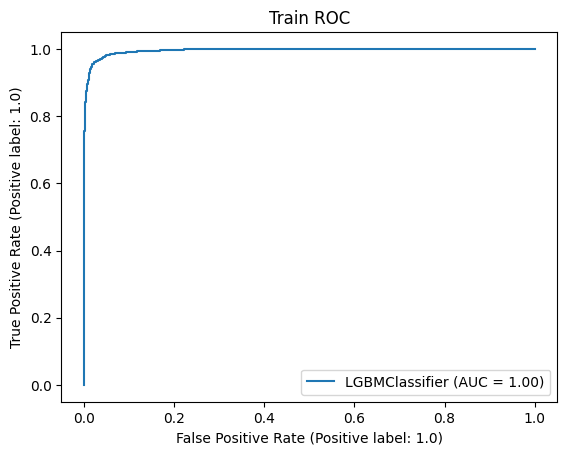

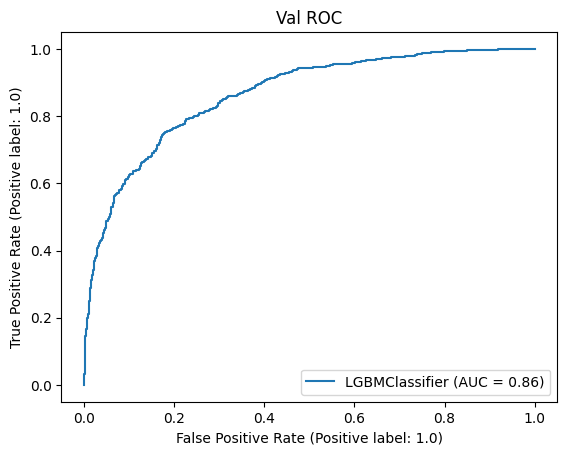

In [22]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title('Train ROC')
plt.show()
RocCurveDisplay.from_estimator(model, X_val, y_val)
plt.title('Val ROC')
plt.show()